Simple outline for this notebook:   

1. Introduce the logic of the current code.

2. Show the whole code of the k-nearest p-median model.

3. Use the example to test the model.

#### 1. The logic

a. The logic of `k_nearest_loop()`.   

It can find the optimal solution, when the coordinate information of clients and facilities and the intial k value are given.

![Flowchart](flowchart/k_nearest_loop()_coordinate.png)

b. The content of `from_sparse_matrix()`

1. Three types of decision variables:   
    one for the pair between clients and facilities,     
    one for the placeholder facilities,     
    one for all the facilities.

2. One objective function

3. Three types of constraints:   
    one is about assignment constraint (each client must be served by one facility);    
    one is about the overall accommodation constraint (the whole facilities are able to serve all the demands);    
    the last one is about the individual capacity constraint (each facility has a capacity)

#### 2. The complete code (binary version + Euclidean distance version)

In [1]:
import pandas as pd
import numpy as np
import pulp
from scipy.sparse import csr_matrix
from scipy.sparse import find
from scipy.spatial import KDTree
from pointpats.geometry import build_best_tree
import geopandas as gpd
from shapely.geometry import Point
from geopandas import GeoDataFrame

/opt/anaconda3/lib/python3.8/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
import pandas as pd
import numpy as np
import pulp
from scipy.sparse import csr_matrix
from scipy.sparse import find
from scipy.spatial import KDTree
from pointpats.geometry import build_best_tree
import geopandas as gpd
from shapely.geometry import Point
from geopandas import GeoDataFrame

def create_sparse_matrix(clients, facilities, k_list, metric):
    """
    create a sparse matrix reprensents the distance between clients and their k nearest facilities
    """
    row_shape = len(clients)
    column_shape = len(facilities)

    # check the k value with the total number of facilities
    for k in k_list:
        if k > column_shape:
            raise ValueError(f"The value of k should be no more than the number of total facilities ({column_shape}).")

    # Initialize empty lists to store the data for the sparse matrix
    data = []
    row_index = []
    col_index = []

    # create the suitable Tree
    tree = build_best_tree(facilities, metric)

    for i, k in enumerate(k_list):
        # Query the Tree to find the k nearest facilities for each client
        distances, k_nearest_facilities_indices = tree.query([clients[i]], k=k)

        # extract the contents of the inner array
        distances = distances[0].tolist()
        k_nearest_facilities_indices = k_nearest_facilities_indices[0].tolist()
        
        # Append the data for the sparse matrix
        data.extend(distances)
        row_index.extend([i] * k)
        col_index.extend(k_nearest_facilities_indices)
    # Create the sparse matrix using csr_matrix
    sparse_matrix = csr_matrix((data, (row_index, col_index)), shape=(row_shape, column_shape))
    return sparse_matrix

def create_k_list(decision_g, k_list):
    """
    increase the k value of client with the g_i > 0, create a new k list
    """
    new_k_list = k_list.copy()
    for i in range(len(decision_g)):
        if decision_g[i].value() > 0:
            new_k_list[i] = new_k_list[i] + 1
    return new_k_list

def from_sparse_matrix(
    sparse_distance_matrix, 
    weights: np.array,
    facility_capacities: np.array = None,
    name: str = "k-nearest-p-median",):
    """
    create and solve a p-median problem of a given sparse distance matrix, and demand and capacity
    """
    # get the indices for clients and facilities
    n_cli = sparse_distance_matrix.shape[0]
    r_cli = range(n_cli)
    r_fac = range(sparse_distance_matrix.shape[1])

    # get the demand/weights
    weights_sum = weights.sum()
    weights = np.reshape(weights, (n_cli, 1))

    # find the indices in this matrix
    row_indices, col_indices, values = find(sparse_distance_matrix)

    # set up the problem
    problem = pulp.LpProblem("k-nearest-p-median", pulp.LpMinimize)

    # set the decision variable for the pair between client and k nearest facilities
    decision = pulp.LpVariable.dicts("x", [(i, j) for i, j in zip(row_indices, col_indices)], 0, 1, pulp.LpBinary)

    # set the decision variable for placeholder facility
    decision_g = pulp.LpVariable.dicts("g", (i for i in r_cli), 0, 1, pulp.LpBinary)

    # set the decision variable for all the facilities
    decision_f = pulp.LpVariable.dicts("y", (j for j in r_fac), 0, 1, pulp.LpBinary)

    # set the objective
    # to complete the objective, we need to get the maximum distance for each client first
    max_distance = sparse_distance_matrix.max(axis=1).toarray().flatten()
    objective = pulp.lpSum(
        pulp.lpSum(
            decision.get((i, j), 0) * sparse_distance_matrix[i, j] for j in r_fac
        )
        + (decision_g[i] * (max_distance[i] + 1))
        for i in r_cli
    )
    problem += objective

    # constraint 1. Each client is assigned to a facility
    for i in r_cli:
        problem += (
            pulp.lpSum(decision.get((i, j), 0) for j in r_fac)
            + decision_g[i] == 1
        )

    # constraint 2. The amount of capacity equals or exceeds the sum of all demands
    problem += pulp.lpSum(decision_f[j] * facility_capacities[j] for j in r_fac) >= weights_sum

    # constraint 3. Demand value the k nearest facility can serve is no more than its capacity.
    for j in col_indices:
        problem += (
            pulp.lpSum(weights[i] * decision.get((i, j), 0) for i in r_cli) <= decision_f[j] * facility_capacities[j]
        )

    problem.solve(pulp.PULP_CBC_CMD(msg=False))
    return problem, decision, decision_g

def k_nearest_loop(
    k_list, 
    gdf_demand : GeoDataFrame,
    gdf_fac : GeoDataFrame,
    demand_col: str,
    facility_col: str,
    weights_cols: str,
    facility_capacity_col: str = None, 
    distance_metric: str = "euclidean",
    name: str = "p-median",
    ):
    """
    the iteration which can find the optimal solution of the given geodataframe of clients and facilities and k value
    """

    # intialize the sum of g_i
    sum_gi = 1

    # create the array of coordinate of clients and facilities
    dem = gdf_demand[demand_col]
    fac = gdf_fac[facility_col]
    dem_data = np.array([dem.x.to_numpy(), dem.y.to_numpy()]).T
    fac_data = np.array([fac.x.to_numpy(), fac.y.to_numpy()]).T

    # demand and capacity
    service_load = gdf_demand[weights_cols].to_numpy()
    facility_capacities = None
    if facility_capacity_col is not None:
        facility_capacities = gdf_fac[facility_capacity_col].to_numpy()

    # start the loop
    while sum_gi > 0:
        sparse_distance_matrix = create_sparse_matrix(dem_data, fac_data, k_list, distance_metric)
        prob, decision, decision_g = from_sparse_matrix(
            sparse_distance_matrix, 
            weights = service_load, 
            facility_capacities = facility_capacities)

        # check the result
        if prob.status != 1:
            print("This problem doesn't have the optimal solution")
            break
        sum_gi = sum(decision_g[i].value() for i in range(len(decision_g)) if decision_g[i].value() > 0)
        if sum_gi > 0:
            k_list = create_k_list(decision_g, k_list)
            
    return prob, decision, decision_g, k_list

#### 3. Test case

##### a. simple case, set the intial k equal to 1, and through the loop, it needs to be increased to 2.

In [4]:
# Sample demand points data
demand_data = {
    'DemandID': [1, 2],
    'geometry': [Point(0.5, 1), Point(1.5, 1)],
    'demand': [1, 1]
}
dem = gpd.GeoDataFrame(demand_data, crs='EPSG:4326')

# Sample facility points data
facility_data = {
    'FacilityID': [101, 102, 103],
    'geometry': [Point(1,1), Point(0, 2), Point(2, 0)],
    'capacity': [1, 1, 1]
}
fac = gpd.GeoDataFrame(facility_data, crs='EPSG:4326')

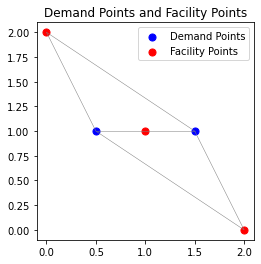

In [5]:
import matplotlib.pyplot as plt
from shapely.geometry import LineString

# Create a plot
fig, ax = plt.subplots()

# Plot demand points and facility points
dem.plot(ax=ax, color='blue', markersize=50, label='Demand Points')
fac.plot(ax=ax, color='red', markersize=50, label='Facility Points')

# Plot connections between demand points and facility points
for i, demand_point in dem.iterrows():
    for j, facility_point in fac.iterrows():
        line = LineString([demand_point.geometry, facility_point.geometry])
        gpd.GeoSeries([line]).plot(ax=ax, color='gray', linewidth=0.5)

# Set plot title and legend
ax.set_title('Demand Points and Facility Points')
ax.legend()

# Show the plot
plt.show()

In [6]:
intial_k = [1, 1]
prob, decision, decision_g, k_list = k_nearest_loop(
    intial_k, 
    dem, 
    fac,
    'geometry',
    'geometry',
    'demand',
    facility_capacity_col = 'capacity',
    distance_metric = "euclidean")

In [7]:
prob.status

1

In [8]:
for i in range(2):
    for j in range(3):
        if (i, j) in decision and decision[(i, j)].value() == 1:
            print(i, j)

0 1
1 0


In [9]:
k_list

[2, 1]

##### b. more complicated case

In [16]:
# Sample demand points data
sample_client_b = np.array([[10.5, 1], [11.5, 1], [13.5, 1], [14.5, 1], [16.5, 1], [17.5, 1]])
demand_data_b = {
    'DemandID': [i + 1 for i in range(len(sample_client_b))],
    'geometry': [Point(x, y) for x, y in sample_client_b],
    'demand': [1] * len(sample_client_b)
}
dem_b = gpd.GeoDataFrame(demand_data_b, crs='EPSG:4326')

# Sample facility points data
sample_facility_b = np.array([[11,1], [10, 2], [12, 0], [14,1], [13, 2], [15, 0], [17,1], [16, 2], [18, 0]])
facility_data_b = {
    'FacilityID': [i + 101 for i in range(len(sample_facility_b))],
    'geometry': [Point(x, y) for x, y in sample_facility_b],
    'capacity': [1] * len(sample_facility_b)
}
fac_b = gpd.GeoDataFrame(facility_data_b, crs='EPSG:4326')

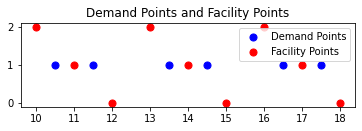

In [17]:
# Create a plot
fig, ax = plt.subplots()

# Plot demand points and facility points
dem_b.plot(ax=ax, color='blue', markersize=50, label='Demand Points')
fac_b.plot(ax=ax, color='red', markersize=50, label='Facility Points')

# Set plot title and legend
ax.set_title('Demand Points and Facility Points')
ax.legend()

# Show the plot
plt.show()

In [20]:
initial_k_b = [1] * len(sample_client_b)
prob_b, decision_b, decision_g_b, k_list_b = k_nearest_loop(
    initial_k_b, 
    dem_b, 
    fac_b,
    'geometry',
    'geometry',
    'demand',
    facility_capacity_col = 'capacity',
    distance_metric = "euclidean")

In [21]:
for i in range(6):
    for j in range(9):
        if (i, j) in decision_b and decision_b[(i, j)].value() == 1:
            print(i, j)

0 1
1 0
2 4
3 3
4 7
5 6


In [22]:
k_list_b

[2, 1, 2, 1, 2, 1]

#### 4. error handling

##### a. the k value should be no more than the total number of facilities

In [23]:
prob, decision, decision_g, k_list = k_nearest_loop(
    [4, 4], 
    dem, 
    fac,
    'geometry',
    'geometry',
    'demand',
    facility_capacity_col = 'capacity',
    distance_metric = "euclidean")

ValueError: The value of k should be no more than the number of total facilities (3).